# Full-fledge DMD Analysis

Using Hanzhen's vectorial approach to the handling of the diffraction efficiency for a DMD.
+ Calculating blazing angles for an incident beam of any latitude `lat` or longitude `lon` (the use of spherical coordinates is definteliy useful here) - what orders are blazed
+ Computing the Fourier Transform of the 2D phase on the DMD
+ Plotting the diffraction efficiency - making sure that for the input parameters chosen, the efficiency is maximal

## Calculate blazing angles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [235]:
LAMBDA = 635e-9 # in m
PITCH = 7.56e-6 # in m
THETA_TILT = np.deg2rad(12) # in degrees
TILT_DIRECTION = np.deg2rad(45+90) # in degrees # tilting in the Y-X direction

In [236]:
# Define useful functions

def unitVecSphericalToCartesianEquator(lat, lon):
    return np.array([
        np.sin(lon) * np.cos(lat),
        np.sin(lat),
        np.cos(lon) * np.cos(lat)
    ])

def unitVecSphereToCartesianNormal(theta, phi): # Z in on top (as Y, in the first function)
    return np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])

def getReflectedVector(normal, incident):
    return incident - 2 * np.dot(incident, normal) * normal

def getPhaseShiftXY(k_i, normal_mirror): # gives the phase shift to the blazing condition in the grating formula
    k_r_mirror = getReflectedVector(normal_mirror, k_i)
    delta_k = (k_i - k_r_mirror) * PITCH / LAMBDA # normalised by units of the DMD spatial frequency

    ## along the x axis
    delta_k_x = delta_k[0]
    mx = np.round(delta_k_x) # Inferior Order
    delta_k_x = np.abs(delta_k_x - mx)
 
    ## along the y axis
    delta_k_y = delta_k[1]
    my = np.round(delta_k_y) # Inferior Order
    delta_k_y = np.abs(delta_k_y - my)

    return delta_k_x, delta_k_y, mx, my


In [463]:
thresh = 1e-2

In [506]:
# Computations
latlong_array = np.linspace(-np.pi/2, np.pi/2, 10_000)

# Define the normal to the mirror
normal_mirror_ON = unitVecSphereToCartesianNormal(THETA_TILT, TILT_DIRECTION)

# Compute phase shifts
phase_shifts = np.zeros((len(latlong_array), len(latlong_array)))
orderX = np.zeros((len(latlong_array), len(latlong_array)))
orderY = np.zeros((len(latlong_array), len(latlong_array)))

for i in range(len(latlong_array)): # iterate on the latitude
    for j in range(len(latlong_array)): # iterate on the longitude
        k_i = unitVecSphericalToCartesianEquator(latlong_array[i], latlong_array[j])
        delta_k_x, delta_k_y, mx, my = getPhaseShiftXY(k_i, normal_mirror_ON)
        phase_shifts[i, j] = np.sqrt(delta_k_x**2 + delta_k_y**2)
        orderX[i, j] = mx
        orderY[i, j] = my

# Extract phase shift for a given latitude
lat_test = np.arctan(np.tan(THETA_TILT)/np.sqrt(2)) # in rad
idx = np.argmin(np.abs(latlong_array - lat_test))
# print(np.rad2deg(latlong_array[idx]))
phaseShiftXYSingleLat = phase_shifts[idx, :]

# Solve minima for the phase shift

# def phaseShiftSingleLatInterval(i, interval_min, interval_max):
#     if i < interval_min or i > interval_max:
#         return np.inf
#     else:
#         return phaseShiftXYSingleLat[int(i)]

blazed_longs_indices = []
for i in range(1, len(phaseShiftXYSingleLat) - 1):
    if phaseShiftXYSingleLat[i-1] > phaseShiftXYSingleLat[i] and phaseShiftXYSingleLat[i] < phaseShiftXYSingleLat[i+1] and phaseShiftXYSingleLat[i] < thresh: # i.e. local minimum
        blazed_longs_indices.append(i)


# # Retrieve the blazed longitudes
# blazed_longs_idx = []
# for interval in intervals:
#     # print(interval)
#     blazed_long_idx = fsolve(phaseShiftSingleLatInterval,  x0 = interval[0], args = (interval[0], interval[1]))
    
#     blazed_longs_idx.append(blazed_long_idx)




KeyboardInterrupt: 

In [472]:
def osc(i):
    return 0.1 if i%2 == 0 else 0

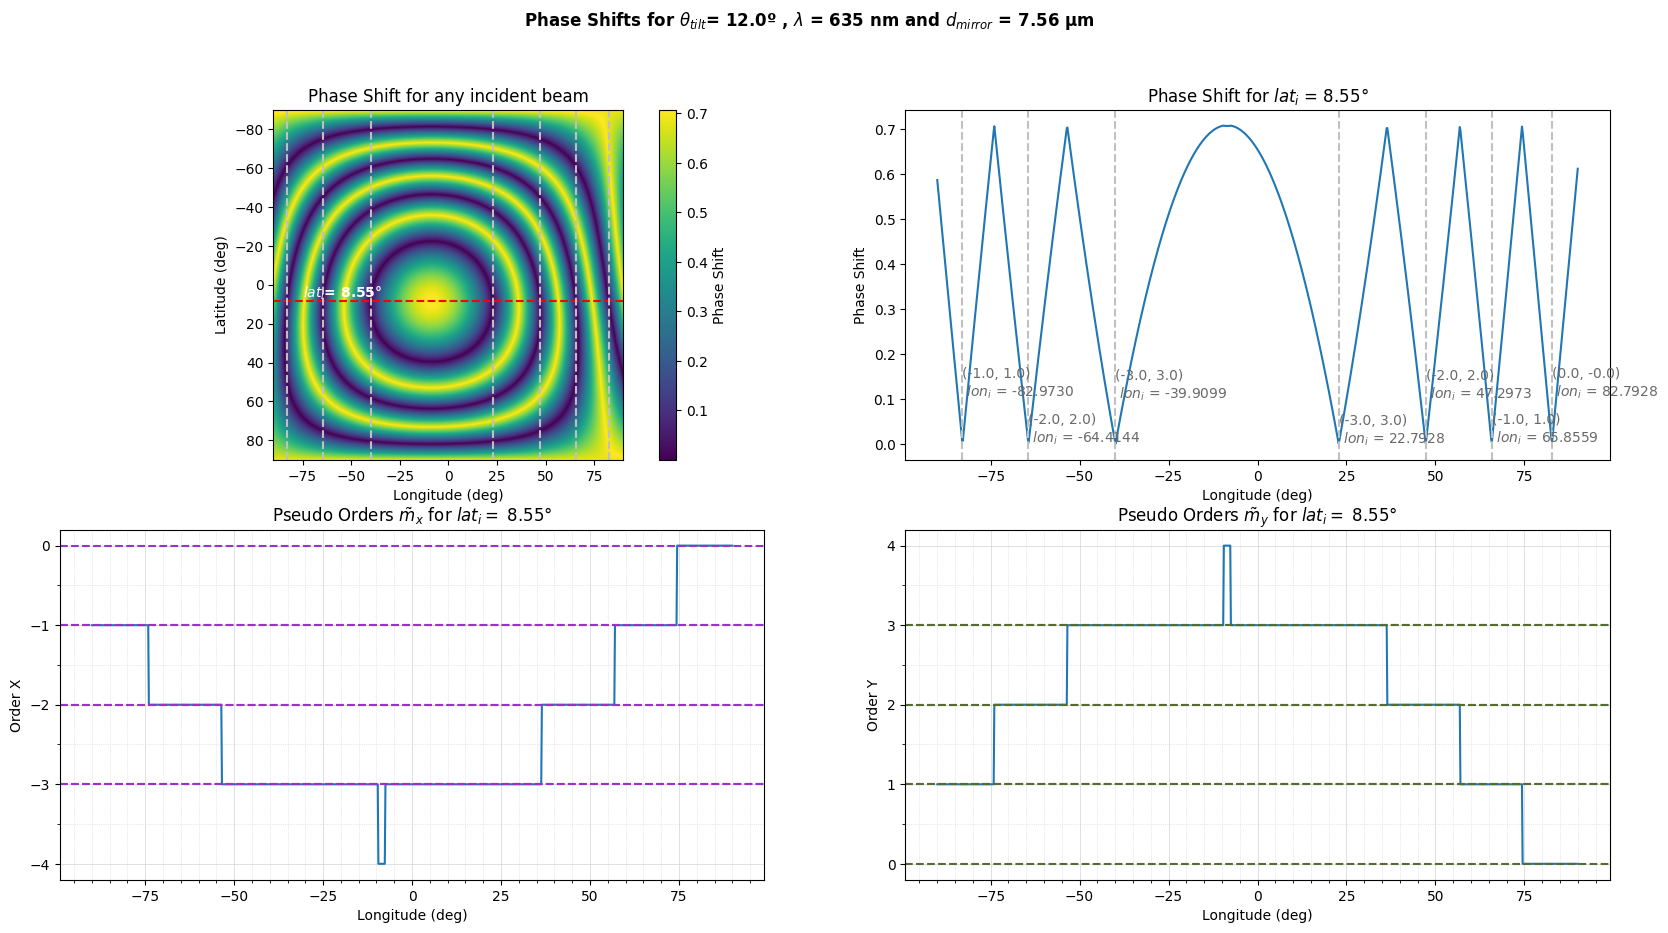

In [473]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle(r'Phase Shifts for $\theta_{tilt}$='+f" {np.rad2deg(THETA_TILT):.1f}º"+ r' , $\lambda$ ='+f" {LAMBDA*10**9:.0f} nm" + r' and $d_{mirror}$ = '+ f"{PITCH*1e6:.2f} µm", fontweight='bold')
# Plot the phase shifts
ax[0, 0].imshow(phase_shifts, extent=[-90, 90, 90, -90], cmap='viridis')
cbar = fig.colorbar(ax[0, 0].images[0], ax=ax[0, 0])
cbar.set_label('Phase Shift')
ax[0, 0].set_xlabel('Longitude (deg)')
ax[0, 0].set_ylabel('Latitude (deg)')
ax[0, 0].set_title('Phase Shift for any incident beam')
ax[0, 0].axhline(y=np.rad2deg(lat_test), color='r', linestyle='--', label = 'Tilt Direction')
ax[0, 0].text(-75, np.rad2deg(lat_test)-2, r'$lat_{i}$='+f' {np.rad2deg(lat_test):.2f}°', color='white', fontweight='bold')

for i in range(len(blazed_longs_indices)):
    blazed_order = (orderX[idx, blazed_longs_indices[i]], orderY[idx, blazed_longs_indices[i]])
    ax[0, 0].axvline(x=np.rad2deg(latlong_array[blazed_longs_indices[i]]), color='silver', linestyle='--', label = f'{blazed_order}')
    # print(np.rad2deg(latlong_array[blazed_longs_indices[i]]))

## Plot for one given latitude
ax[0, 1].plot(np.rad2deg(latlong_array), phaseShiftXYSingleLat)
ax[0, 1].set_xlabel('Longitude (deg)')
ax[0, 1].set_ylabel('Phase Shift')
ax[0, 1].set_title(f'Phase Shift for ' + r'$lat_{i}$ = ' + f'{np.rad2deg(lat_test):.2f}°')

# Add vertical lines for blazed orders
for i in range(len(blazed_longs_indices)):
    blazed_order = (orderX[idx, blazed_longs_indices[i]], orderY[idx, blazed_longs_indices[i]])
    ax[0, 1].axvline(x=np.rad2deg(latlong_array[int(blazed_longs_indices[i])]), color='silver', linestyle='--', label = f'{blazed_order}')
    ax[0, 1].text(np.rad2deg(latlong_array[blazed_longs_indices[i]]), phaseShiftXYSingleLat[blazed_longs_indices[i]]+ osc(i), f'{blazed_order} \n '+r'$lon_{i}$ ='+ f' {np.rad2deg(latlong_array[blazed_longs_indices[i]]):.4f}', color='dimgray')

# Plot pseudo_orders
ax[1,0].plot(np.rad2deg(latlong_array), orderX[idx, :])
ax[1,1].plot(np.rad2deg(latlong_array), orderY[idx, :])
ax[1,0].set_xlabel('Longitude (deg)')
ax[1,0].set_ylabel('Order X')
ax[1,0].set_title('Pseudo Orders '+r'$\tilde{m}_x$'+ ' for ' + r'$lat_{i}=$' + f' {np.rad2deg(lat_test):.2f}°')

ax[1,1].set_xlabel('Longitude (deg)')
ax[1,1].set_ylabel('Order Y')
ax[1,1].set_title('Pseudo Orders '+r'$\tilde{m}_y$'+ ' for ' + r'$lat_{i}=$' + f' {np.rad2deg(lat_test):.2f}°')

for i in range(len(blazed_longs_indices)):
    blazed_order = (orderX[idx, blazed_longs_indices[i]], orderY[idx, blazed_longs_indices[i]])
    ax[1, 0].axhline(y=orderX[idx, blazed_longs_indices[i]], color='darkorchid', linestyle='--', label = f'{blazed_order}')
    ax[1, 1].axhline(y=orderY[idx, blazed_longs_indices[i]], color='darkolivegreen', linestyle='--', label = f'{blazed_order}')
    
    
    # Set grid for ax[1, 0]
    ax[1, 0].grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='lightgray')
    ax[1, 0].grid(which='minor', axis='x', linestyle=':', linewidth='0.5', color='lightgray')
    ax[1, 0].grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='lightgray')
    ax[1, 0].grid(which='minor', axis='y', linestyle=':', linewidth='0.5', color='lightgray')
    ax[1, 0].xaxis.set_major_locator(plt.MultipleLocator(25))
    ax[1, 0].xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax[1, 0].yaxis.set_major_locator(plt.MultipleLocator(1))
    ax[1, 0].yaxis.set_minor_locator(plt.MultipleLocator(0.5))

    # Set grid for ax[1, 1]
    ax[1, 1].grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='lightgray')
    ax[1, 1].grid(which='minor', axis='x', linestyle=':', linewidth='0.5', color='lightgray')
    ax[1, 1].grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='lightgray')
    ax[1, 1].grid(which='minor', axis='y', linestyle=':', linewidth='0.5', color='lightgray')
    ax[1, 1].xaxis.set_major_locator(plt.MultipleLocator(25))
    ax[1, 1].xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax[1, 1].yaxis.set_major_locator(plt.MultipleLocator(1))
    ax[1, 1].yaxis.set_minor_locator(plt.MultipleLocator(0.5))

## 2D Fourier Transform of the DMD
All-ON mode

In [247]:
# Parameters of the simulation
N = 27 # number of mirrors per line (Y)
M = 48 # number of mirrors per column (X)
d = 0.90*PITCH # size of the mirror in the X and Y (m)
g = 0.10*PITCH # gap between the mirrors in the X and Y (m)
res = 30 # number of pixels per mirror (for numerical calculation purposes)
Npx = N*res # number of pixels in Y
Mpx = M*res # number of pixels in X

In [507]:
# Define incident wave vector
lat_in = np.arctan(np.tan(THETA_TILT)/np.sqrt(2))  # in rad
lon_in = np.deg2rad(-82.9730)

k_i = unitVecSphericalToCartesianEquator(lat_in, lon_in)
k_r = getReflectedVector(normal_mirror_ON, k_i)

In [508]:
# Define the states of the mirrors
f = np.ones([N, M]) # All mirrors are on

# Define the XY coordinates with a meshgrid (iterable)
X, Y = np.meshgrid(np.arange(Mpx), np.arange(Npx))

# Define the phase at the interface of each mirror
step = PITCH/res
phi = np.exp(1j * 2 * np.pi / LAMBDA * (X * step * (k_i[0] - k_r[0])+ Y * step * (k_i[1] - k_r[1])) )
# phi = np.exp(-1j * 2 * np.pi/LAMBDA * np.dot(np.array([X.flatten(), Y.flatten()]).T, (k_i - k_r)) ).reshape(Npx, Mpx)

# Define the active area of the mirror in pixels(remove the gap)
cell = np.zeros([res, res])
gpx = int(np.round(g/(2*PITCH)*res)) # gap in pixels
cell[gpx:res-gpx, gpx:res-gpx] = 1. # active area of the mirror

# Build the phase image
MI = np.zeros([Npx, Mpx], dtype=complex)
for i in range(Npx):
    for j in range(Mpx):
        # MI[i*res:(i+1)*res, j*res:(j+1)*res] = f[i,j] * phi[i,j] * cell
        MI[i,j] = phi[i,j]*f[i//res, j//res]*cell[i%res, j%res]

In [509]:
# # plt.figure(figsize=(8, 8))
# plt.imshow(np.real(MI))
# plt.colorbar( fraction=0.046, pad=0.04)
# plt.title('Phase on the DMD array \n' + r'($\theta_i$ = ' + f'{np.degrees(lat_in):.2f}º, ' + r'$\phi_i$ = ' + f'{np.degrees(lon_in):.2f}º, ' + r'$\theta_{tilt}$ = ' + f'{np.degrees(THETA_TILT):.2f}º, N = {N} px)')
# plt.xlabel('X [px]')
# plt.ylabel('Y [px]')

In [510]:
# Fourier Transform of the plane

# Define the size of the output
coeff = 5

# Compute the 2D discrete Fourier Transform
FT = np.fft.fft2(MI, s=[coeff*Npx, coeff*Mpx])

# Shift the zero frequency component to the center
FT = np.fft.fftshift(FT)

FT = np.abs(FT)
# Define the ROI in the Fourier Plane
ROI_radius = 300

# Crop FT to ROI, starting from the center
FT = FT[coeff*Npx//2-ROI_radius:coeff*Npx//2+ROI_radius, coeff*Mpx//2-ROI_radius:coeff*Mpx//2+ROI_radius]

# Normalise FT
FT = FT/np.sum(FT)

In [511]:
## Extract 1D distribution of the FT, for y = 1

# Find the centroid of the image, i.e. where there is the order with the highest intensity
centroid = np.unravel_index(np.argmax(FT, axis=None), FT.shape)
print(centroid)

# compute the centroid as the averages in x and y weighted by the intensity
# centroid = np.array([np.average(np.arange(FT.shape[0]), weights=np.sum(FT, axis=1)), np.average(np.arange(FT.shape[1]), weights=np.sum(FT, axis=0))], dtype=int)
# print(centroid)

# Derive the 1D intensity profiles along the x and y axis passing by the centroid
FT_x = FT[centroid[0], :]**2
FT_y = FT[:, centroid[1]]**2

# Take a square around the centroid of radius ROI_radius/8
FT_max_order = FT[centroid[0]-ROI_radius//8:centroid[0]+ROI_radius//8, centroid[1]-ROI_radius//8:centroid[1]+ROI_radius//8]**2


# Derive the ratio of the intensity in this order to the total intensity

order_intensity = np.sum(FT_max_order)
ratio_intensity = order_intensity/np.sum(FT**2)
print(ratio_intensity)



(434, 61)
0.8707174139790849


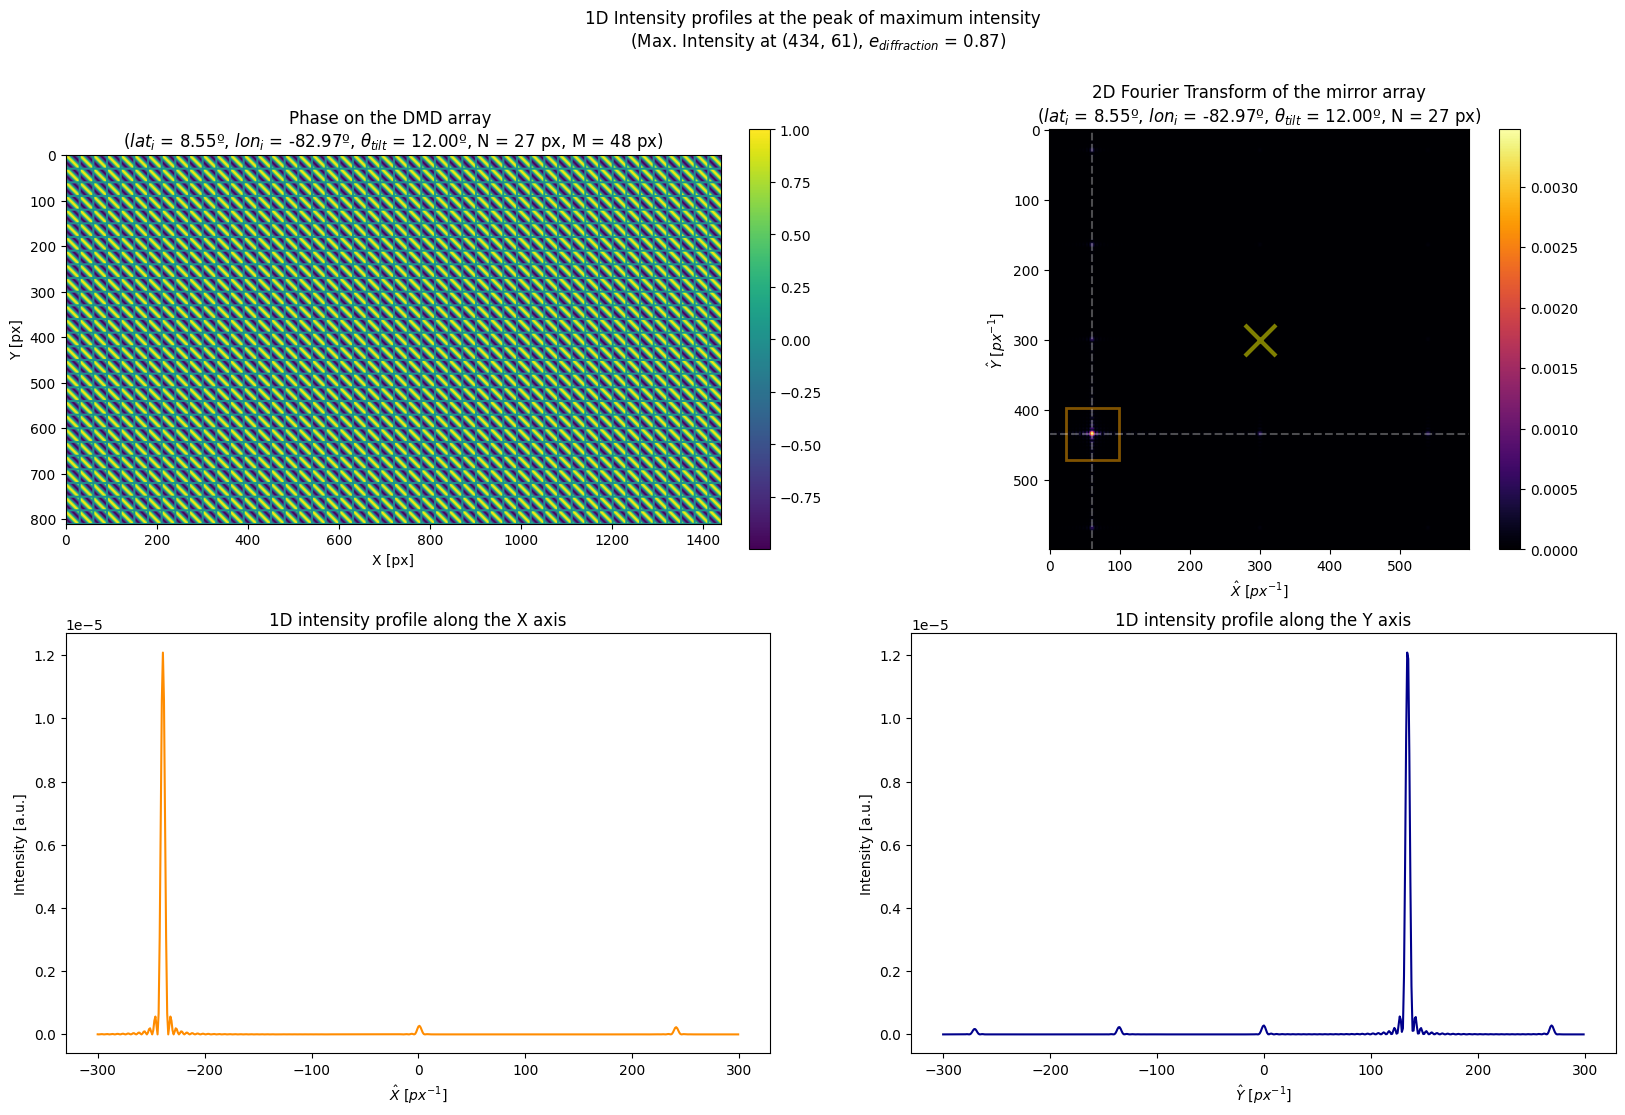

In [512]:
# Plot the 1D intensity profiles in a 1x2 axis grid
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax[1, 0].plot(np.arange(-ROI_radius, ROI_radius), FT_x, color='darkorange')
ax[1, 0].set_title('1D intensity profile along the X axis')
ax[1, 0].set_xlabel(r'$\hat{X}$ [$px^{-1}$]')
ax[1, 0].set_ylabel('Intensity [a.u.]')

ax[1, 1].plot(np.arange(-ROI_radius, ROI_radius), FT_y, color='darkblue')
ax[1, 1].set_title('1D intensity profile along the Y axis')
ax[1, 1].set_xlabel(r'$\hat{Y}$ [$px^{-1}$]')
ax[1, 1].set_ylabel('Intensity [a.u.]')

fig.suptitle('1D Intensity profiles at the peak of maximum intensity \n (Max. Intensity at '+f'({centroid[0]}, {centroid[1]}), '+ r'$e_{diffraction}$ = '+ f'{ratio_intensity:.2f})')

# Plot the Fourier Transform

# plot the phase pattern on the DMD
ax[0, 0].imshow(np.real(MI))
cbar0 = fig.colorbar(ax[0, 0].images[0], ax=ax[0, 0], fraction=0.03, pad=0.04)

ax[0, 0].set_title('Phase on the DMD array \n' + r'($lat_i$ = ' + f'{np.degrees(lat_in):.2f}º, ' + r'$lon_{i}$ = ' + f'{np.degrees(lon_in):.2f}º, ' + r'$\theta_{tilt}$ = ' + f'{np.degrees(THETA_TILT):.2f}º, N = {N} px, M = {M} px)')
ax[0, 0].set_xlabel('X [px]')
ax[0, 0].set_ylabel('Y [px]')


ax[0, 1].imshow(FT, cmap='inferno')
cbar1 = fig.colorbar(ax[0, 1].images[0], ax=ax[0, 1], fraction=0.04, pad=0.04)
# ax[1].set_clim([0,(np.max(FT)/5)]) # increase denomintor to get better contrast
ax[0, 1].scatter(ROI_radius, ROI_radius, s=500,alpha = 0.5,c='yellow',linewidths= 3.,  marker='x')
ax[0, 1].set_title('2D Fourier Transform of the mirror array\n'+r'($lat_i$ = ' + f'{np.degrees(lat_in):.2f}º, ' + r'$lon_{i}$ = ' + f'{np.degrees(lon_in):.2f}º, ' + r'$\theta_{tilt}$ = ' + f'{np.degrees(THETA_TILT):.2f}º, N = {N} px)')
ax[0, 1].set_xlabel(r'$\hat{X}$ [$px^{-1}$]')
ax[0, 1].set_ylabel(r'$\hat{Y}$ [$px^{-1}$]')

# Center the plot window in ax[0,1] better
ax[0, 1].title.set_position([0.5, 1.05])
cbar1.ax.set_position([ax[0, 1].get_position().x1 - 0.03, ax[0, 1].get_position().y0, 0.02, ax[0, 1].get_position().height])
ax[0,1].set_position([ax[0, 1].get_position().x0 - 0.045, ax[0, 1].get_position().y0, ax[0, 1].get_position().width, ax[0, 1].get_position().height])

# Plot two lines on ax[0,1] to show where the 1D profiles are taken
ax[0, 1].axvline(x=centroid[1], color='white', linestyle='--', alpha=0.3)
ax[0, 1].axhline(y=centroid[0], color='white', linestyle='--', alpha=0.3)

# Draw the box on ax[0, 1]
rect = plt.Rectangle((centroid[1]-ROI_radius//8, centroid[0]-ROI_radius//8), ROI_radius//4, ROI_radius//4, linewidth=2, edgecolor='orange', alpha = 0.5, facecolor='none')
ax[0, 1].add_patch(rect)



plt.show()

## Diffraction efficiency per longitude
All-ON mode

In [437]:
lat_i = np.deg2rad(8.5)
lon_array = np.linspace(-np.pi/2, np.pi/2, 360) # step of 0.5 degrees

# Define size of the outpout of the numpy fft
coeff = 5

# Define ROI radius
ROI_radius = 300

In [438]:
diffraction_efficiency = np.empty_like(lon_array)

In [441]:
for k in range(len(lon_array)):
    lon = lon_array[k]
    k_i = unitVecSphericalToCartesianEquator(lat_i, lon)
    k_r = getReflectedVector(normal_mirror_ON, k_i)

    # Define the states of the mirrors
    f = np.ones([N, M]) # All mirrors are on

    # Define the XY coordinates with a meshgrid (iterable)
    X, Y = np.meshgrid(np.arange(Mpx), np.arange(Npx))

    # Define the phase at the interface of each mirror
    step = PITCH/res
    phi = np.exp(1j * 2 * np.pi / LAMBDA * (X * step * (k_i[0] - k_r[0])+ Y * step * (k_i[1] - k_r[1])) )
    # phi = np.exp(-1j * 2 * np.pi/LAMBDA * np.dot(np.array([X.flatten(), Y.flatten()]).T, (k_i - k_r)) ).reshape(Npx, Mpx)

    # Define the active area of the mirror in pixels(remove the gap)
    cell = np.zeros([res, res])
    gpx = int(np.round(g/(2*PITCH)*res)) # gap in pixels
    cell[gpx:res-gpx, gpx:res-gpx] = 1. # active area of the mirror

    # Build the phase image
    MI = np.zeros([Npx, Mpx], dtype=complex)
    for i in range(Npx):
        for j in range(Mpx):
            # MI[i*res:(i+1)*res, j*res:(j+1)*res] = f[i,j] * phi[i,j] * cell
            MI[i,j] = phi[i,j]*f[i//res, j//res]*cell[i%res, j%res]


    # Compute the 2D discrete Fourier Transform
    # Fourier Transform of the plane

    # Compute the 2D discrete Fourier Transform
    FT = np.fft.fft2(MI, s=[coeff*Npx, coeff*Mpx])

    # Shift the zero frequency component to the center
    FT = np.fft.fftshift(FT)

    # Crop FT to the ROI
    FT = FT[coeff*Npx//2-ROI_radius:coeff*Npx//2+ROI_radius, coeff*Mpx//2-ROI_radius:coeff*Mpx//2+ROI_radius]

    # Normalise FT
    FT = FT/np.sum(FT)
    FT = np.abs(FT)

    # Find the centroid of the image, i.e. where there is the order with the highest intensity
    centroid = np.unravel_index(np.argmax(FT, axis=None), FT.shape)

    # Take a square around the centroid of radius ROI_radius/8
    FT_max_order = FT[centroid[0]-ROI_radius//8:centroid[0]+ROI_radius//8, centroid[1]-ROI_radius//8:centroid[1]+ROI_radius//8]**2

    # Derive the ratio of the intensity in this order to the total intensity
    order_intensity = np.sum(FT_max_order)
    total_intensity = np.sum(FT**2)
    ratio_intensity = order_intensity/total_intensity

    # Store
    diffraction_efficiency[k] = ratio_intensity

    

In [442]:
# Compute phase shift for the given latitude
idx = np.argmin(np.abs(latlong_array - lat_i))
phase_shift_lat_i = phase_shifts[idx, :]

In [443]:
# Compute the blazed longitudes
blazed_longs_indices = []
for i in range(1, len(phase_shift_lat_i) - 1):
    if phase_shift_lat_i[i-1] > phase_shift_lat_i[i] and phase_shift_lat_i[i] < phase_shift_lat_i[i+1]: # i.e. local minimum
        blazed_longs_indices.append(i)

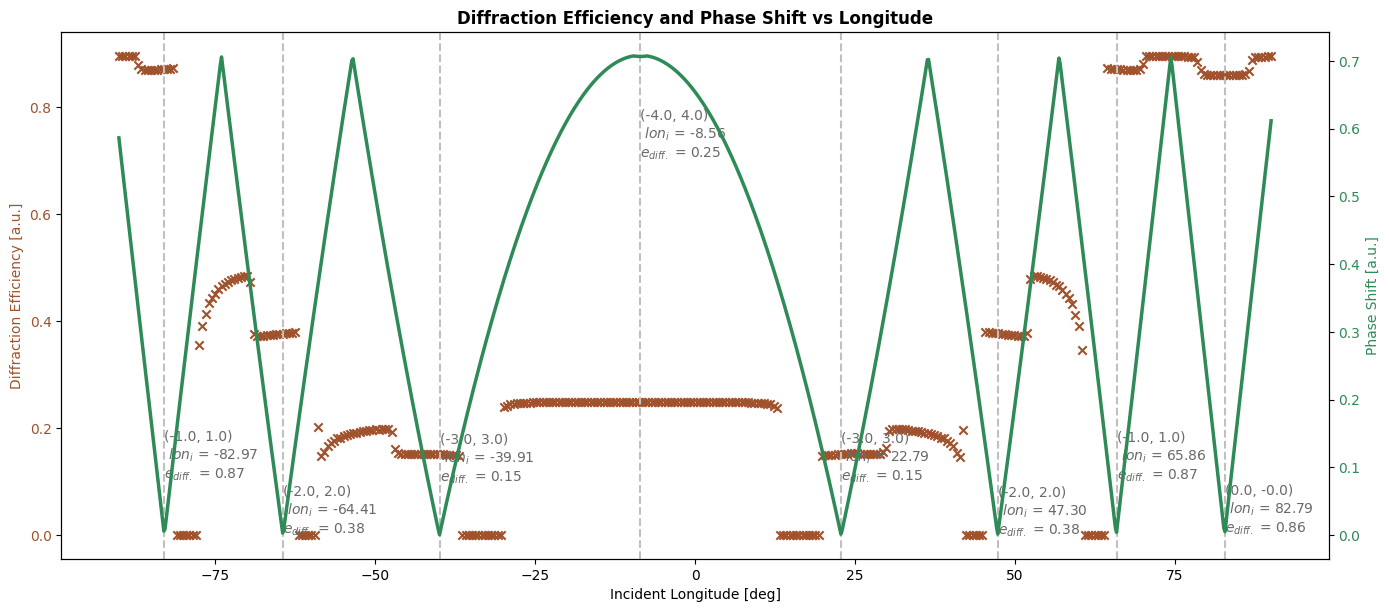

In [447]:
# Plot the diffraction efficiency
from tkinter import font
from pyparsing import line


fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('Incident Longitude [deg]')
ax1.set_ylabel('Diffraction Efficiency [a.u.]', color='sienna')
ax1.scatter(np.rad2deg(lon_array), diffraction_efficiency, marker='x', color='sienna', label=r'$e_{diffraction}$')
ax1.tick_params(axis='y', labelcolor='sienna')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Phase Shift [a.u.]', color='seagreen')  # we already handled the x-label with ax1
ax2.plot(np.rad2deg(latlong_array), phase_shift_lat_i, color='seagreen', label='Phase Shift', linewidth=2.5)
ax2.tick_params(axis='y', labelcolor='seagreen')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Diffraction Efficiency and Phase Shift vs Longitude', fontweight='bold')

# Plot the blazed longitudes
for i in range(len(blazed_longs_indices)):
    blazed_order = (orderX[idx, blazed_longs_indices[i]], orderY[idx, blazed_longs_indices[i]])
    ax1.axvline(x=np.rad2deg(latlong_array[blazed_longs_indices[i]]), color='silver', linestyle='--', label = f'{blazed_order}')
    # print(np.rad2deg(latlong_array[blazed_longs_indices[i]]))
    
    # Compute the index of lon_array that corresponds to the blazed longitude
    indx_lon = np.argmin(np.abs(lon_array - latlong_array[blazed_longs_indices[i]]))

    ax1.text(np.rad2deg(latlong_array[blazed_longs_indices[i]]), phase_shift_lat_i[blazed_longs_indices[i]]+ osc(i), f'{blazed_order} \n '+r'$lon_{i}$ ='+ f' {np.rad2deg(latlong_array[blazed_longs_indices[i]]):.2f} \n'+ r'$e_{diff.}$'+f' = {diffraction_efficiency[indx_lon]:.2f}', color='dimgray')

plt.show()